# 03_tml_pca

We will stack PCA onto the 02 series notebooks to try and reduce the dimensions of our data. We think that not all features are important

In [1]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [3]:
# load data
train = pd.read_csv(root_dir/"data/train.csv")
test = pd.read_csv(root_dir/"data/test.csv")
print("data loaded")

data loaded


In [4]:
# check shape
print(train.shape)
print(test.shape)

(280145, 138)
(120504, 138)


In [5]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


In [6]:
# scaling data to make it easier for models to train
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

# test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
x_test = scaler.transform(x_test)

# Helper functions

In [7]:
# constants
SEED = 42

In [8]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [9]:
def model_scores(model, test=test, x_test=x_test, y_test=y_test):
  y_pred = model.predict(x_test) 

  print("Utility score: ", utility_score(test, y_pred))
  print("Accuracy: ", accuracy_score(y_test, y_pred))
  
  print("Confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(3, 3))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  plt.show()  

  print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

# PCA
The idea behind PCA is to take the original features and compress them into a smaller set of features, while still keeping as much information as possible. As such, if we are compressing into k features, the 1st feature will retain as much % of the variance represented by the data and so on.

The end result is k features, but of note is that the new features have no logical meaning anymore since they are representations of a few features. This is fine as our features are anonymous to begin with - but an important point is that now we have to change our original data to fit the new transformed feature space.

In [10]:
# import model
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# settings to vary
max_depths = [2,4,8,16,32,64]
splitters = ['best', 'random']
max_features = [None, 'sqrt', 'log2']

In [11]:
# import model
from sklearn import decomposition

# settings to vary
n_components = [70, 90, 110, 130]



Decision Tree model: max_depth=2, splitter=best, max_feature=None, n_components=70
Utility score:  168.82493554302337
Accuracy:  0.5189039367987784
Confusion matrix


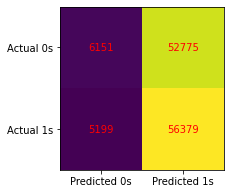

AUC_ROC


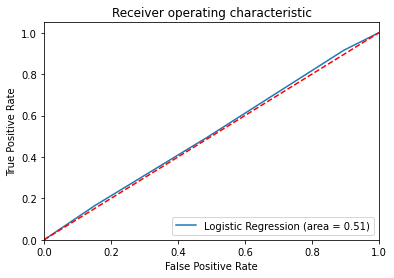



Decision Tree model: max_depth=2, splitter=best, max_feature=None, n_components=90
Utility score:  168.82493554302337
Accuracy:  0.5189039367987784
Confusion matrix


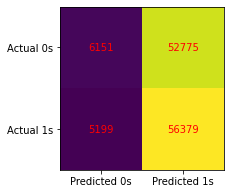

AUC_ROC


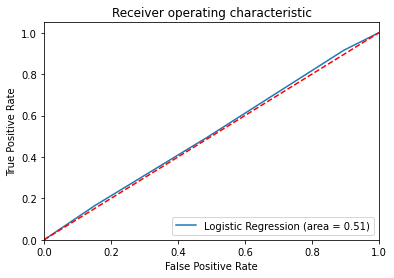



Decision Tree model: max_depth=2, splitter=best, max_feature=None, n_components=110
Utility score:  168.82493554302337
Accuracy:  0.5189039367987784
Confusion matrix


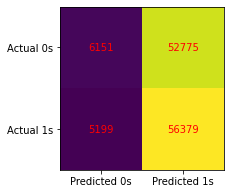

AUC_ROC


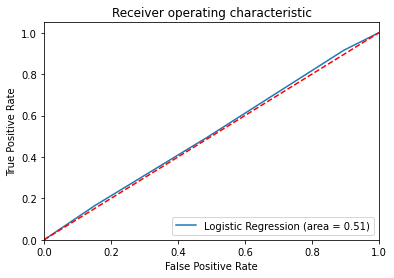



Decision Tree model: max_depth=2, splitter=best, max_feature=None, n_components=130
Utility score:  168.82493554302337
Accuracy:  0.5189039367987784
Confusion matrix


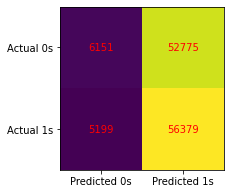

AUC_ROC


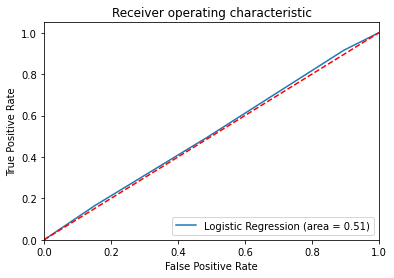



Decision Tree model: max_depth=2, splitter=best, max_feature=sqrt, n_components=70
Utility score:  -0.0
Accuracy:  0.5104062935670185
Confusion matrix


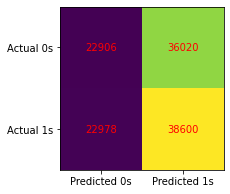

AUC_ROC


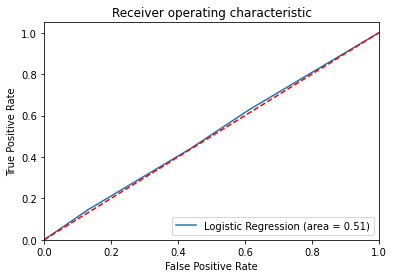



Decision Tree model: max_depth=2, splitter=best, max_feature=sqrt, n_components=90
Utility score:  -0.0
Accuracy:  0.5110037841067516
Confusion matrix


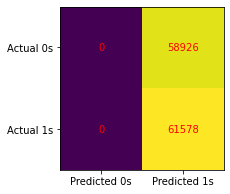

AUC_ROC


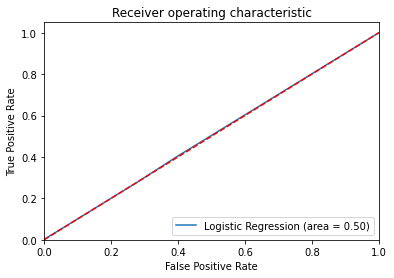



Decision Tree model: max_depth=2, splitter=best, max_feature=sqrt, n_components=110
Utility score:  34.93082879550965
Accuracy:  0.5031617207727545
Confusion matrix


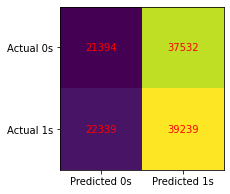

AUC_ROC


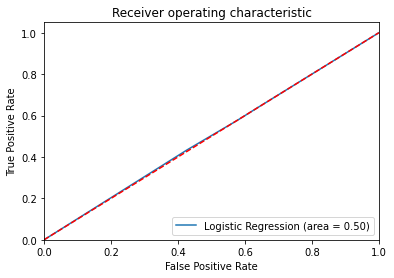



Decision Tree model: max_depth=2, splitter=best, max_feature=sqrt, n_components=130
Utility score:  38.21171896865026
Accuracy:  0.5083482705968266
Confusion matrix


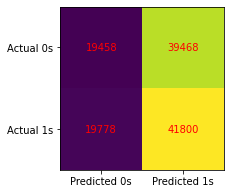

AUC_ROC


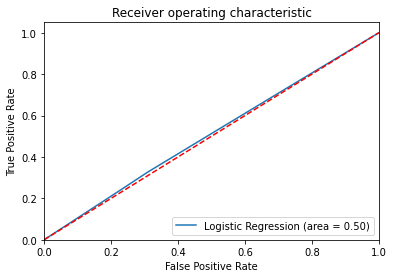



Decision Tree model: max_depth=2, splitter=best, max_feature=log2, n_components=70
Utility score:  -0.0
Accuracy:  0.5110037841067516
Confusion matrix


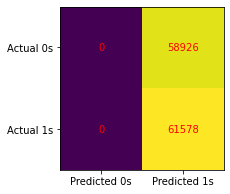

AUC_ROC


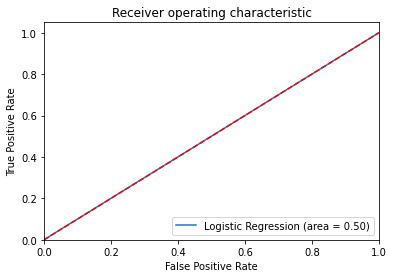



Decision Tree model: max_depth=2, splitter=best, max_feature=log2, n_components=90
Utility score:  -0.0
Accuracy:  0.5110037841067516
Confusion matrix


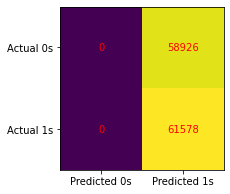

AUC_ROC


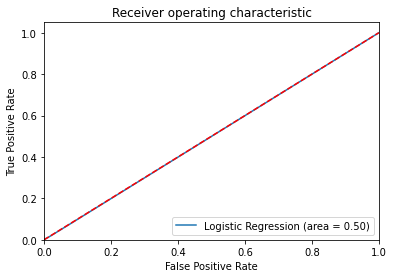



Decision Tree model: max_depth=2, splitter=best, max_feature=log2, n_components=110
Utility score:  3.7607451783815513
Accuracy:  0.5095266547168559
Confusion matrix


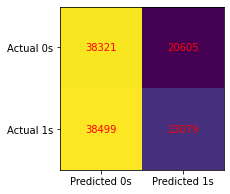

AUC_ROC


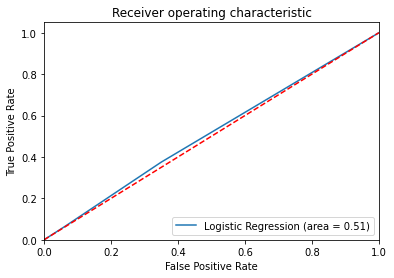



Decision Tree model: max_depth=2, splitter=best, max_feature=log2, n_components=130
Utility score:  -0.0
Accuracy:  0.5116095731262033
Confusion matrix


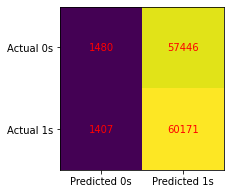

AUC_ROC


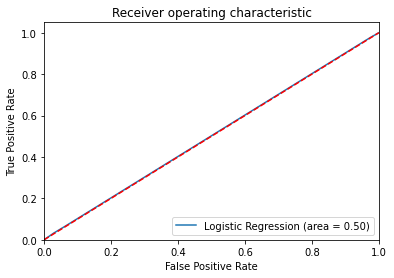



Decision Tree model: max_depth=2, splitter=random, max_feature=None, n_components=70
Utility score:  -0.0
Accuracy:  0.5110037841067516
Confusion matrix


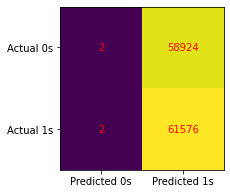

AUC_ROC


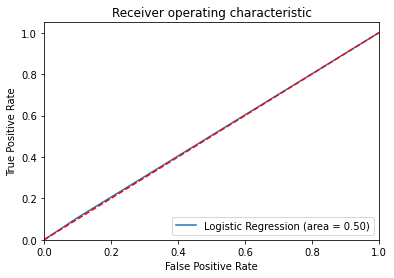



Decision Tree model: max_depth=2, splitter=random, max_feature=None, n_components=90
Utility score:  -0.0
Accuracy:  0.5068130518489012
Confusion matrix


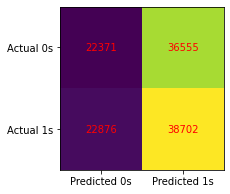

AUC_ROC


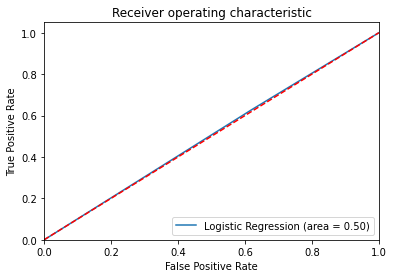



Decision Tree model: max_depth=2, splitter=random, max_feature=None, n_components=110
Utility score:  -0.0
Accuracy:  0.5110037841067516
Confusion matrix


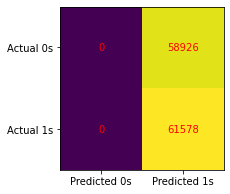

AUC_ROC


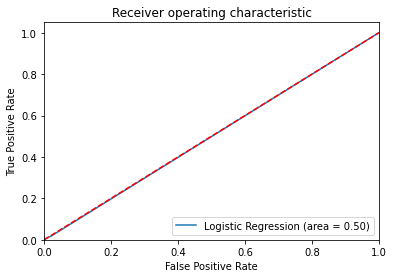



Decision Tree model: max_depth=2, splitter=random, max_feature=None, n_components=130
Utility score:  -0.0
Accuracy:  0.5110037841067516
Confusion matrix


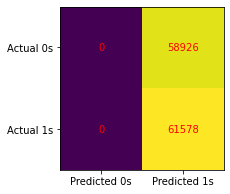

AUC_ROC


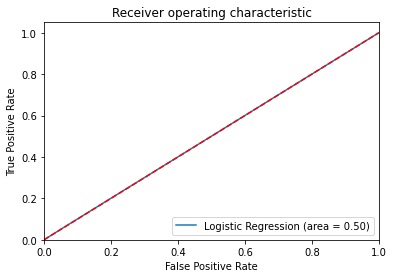



Decision Tree model: max_depth=2, splitter=random, max_feature=sqrt, n_components=70
Utility score:  -0.0
Accuracy:  0.5110867689039368
Confusion matrix


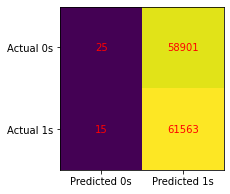

AUC_ROC


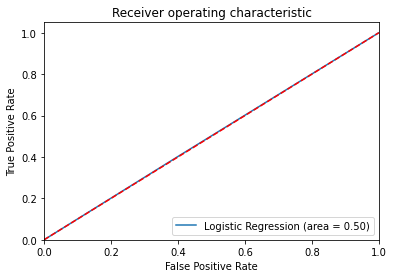



Decision Tree model: max_depth=2, splitter=random, max_feature=sqrt, n_components=90
Utility score:  -0.0
Accuracy:  0.5116510655247959
Confusion matrix


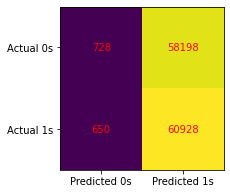

AUC_ROC


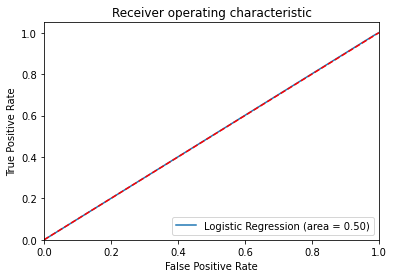



Decision Tree model: max_depth=2, splitter=random, max_feature=sqrt, n_components=110
Utility score:  -0.0
Accuracy:  0.510945694748722
Confusion matrix


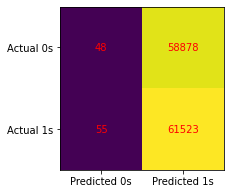

AUC_ROC


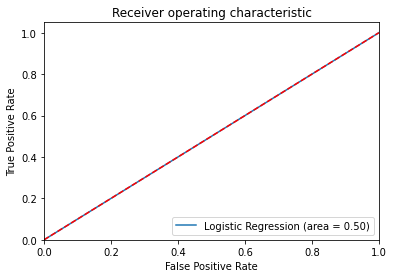



Decision Tree model: max_depth=2, splitter=random, max_feature=sqrt, n_components=130
Utility score:  -0.0
Accuracy:  0.5118502290380402
Confusion matrix


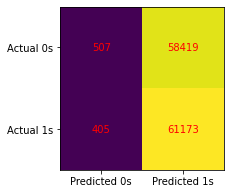

AUC_ROC


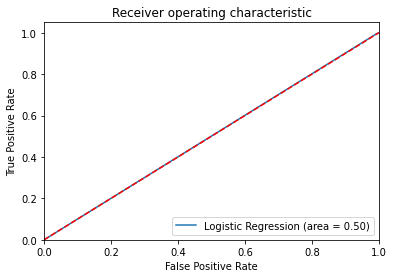



Decision Tree model: max_depth=2, splitter=random, max_feature=log2, n_components=70
Utility score:  -0.0
Accuracy:  0.5121157803890327
Confusion matrix


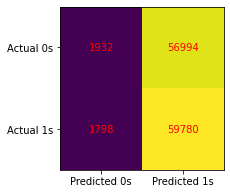

AUC_ROC


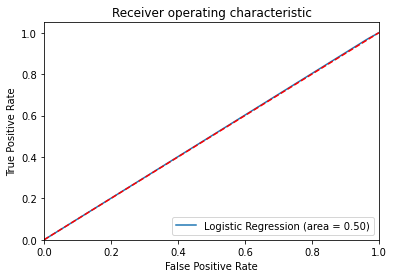



Decision Tree model: max_depth=2, splitter=random, max_feature=log2, n_components=90
Utility score:  -0.0
Accuracy:  0.5117838412002921
Confusion matrix


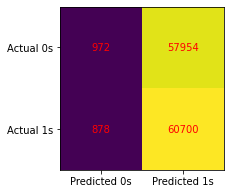

AUC_ROC


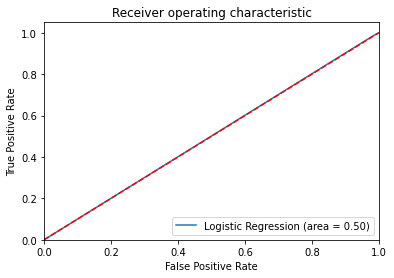



Decision Tree model: max_depth=2, splitter=random, max_feature=log2, n_components=110
Utility score:  -0.0
Accuracy:  0.5107963221137888
Confusion matrix


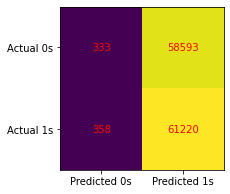

AUC_ROC


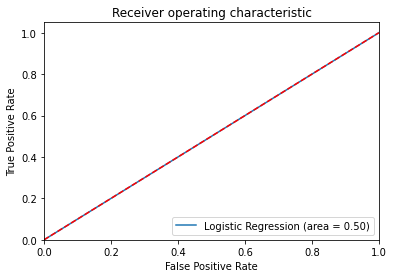



Decision Tree model: max_depth=2, splitter=random, max_feature=log2, n_components=130
Utility score:  -0.0
Accuracy:  0.5111116643430923
Confusion matrix


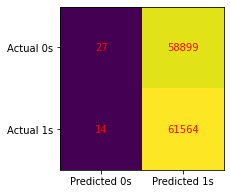

AUC_ROC


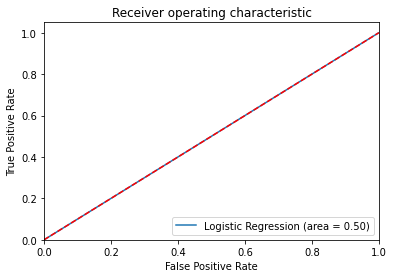



Decision Tree model: max_depth=4, splitter=best, max_feature=None, n_components=70
Utility score:  140.03481101681365
Accuracy:  0.5079416450906195
Confusion matrix


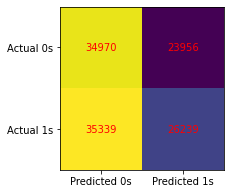

AUC_ROC


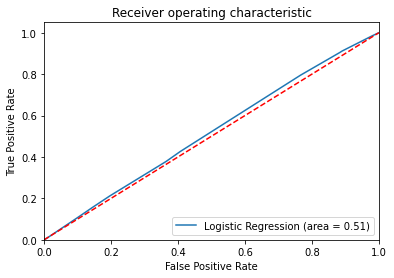



Decision Tree model: max_depth=4, splitter=best, max_feature=None, n_components=90
Utility score:  135.64201941089974
Accuracy:  0.5076594967801898
Confusion matrix


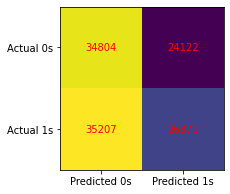

AUC_ROC


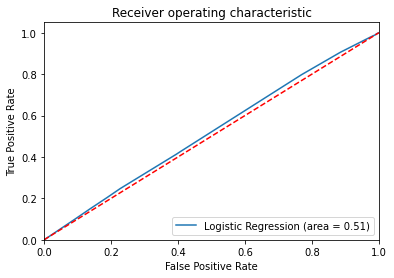



Decision Tree model: max_depth=4, splitter=best, max_feature=None, n_components=110
Utility score:  135.64201941089974
Accuracy:  0.5076594967801898
Confusion matrix


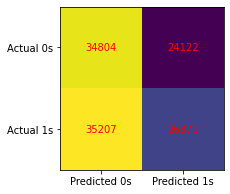

AUC_ROC


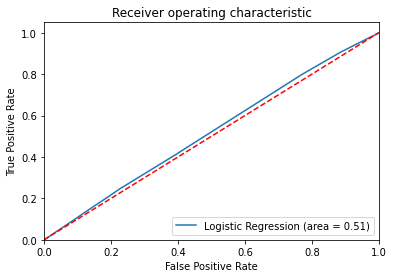



Decision Tree model: max_depth=4, splitter=best, max_feature=None, n_components=130
Utility score:  135.64201941089974
Accuracy:  0.5076594967801898
Confusion matrix


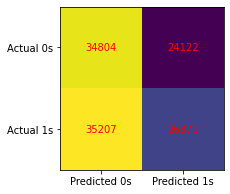

AUC_ROC


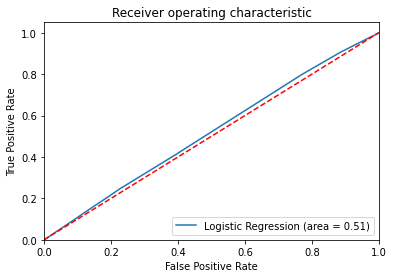



Decision Tree model: max_depth=4, splitter=best, max_feature=sqrt, n_components=70
Utility score:  47.624081774169426
Accuracy:  0.5068960366460864
Confusion matrix


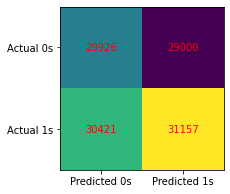

AUC_ROC


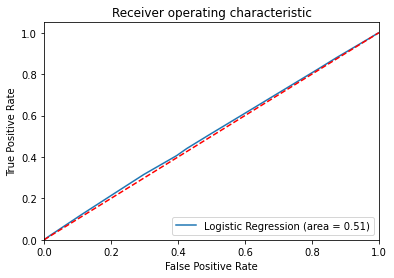



Decision Tree model: max_depth=4, splitter=best, max_feature=sqrt, n_components=90
Utility score:  13.790444718489587
Accuracy:  0.5109788886675961
Confusion matrix


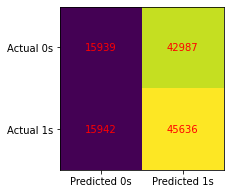

AUC_ROC


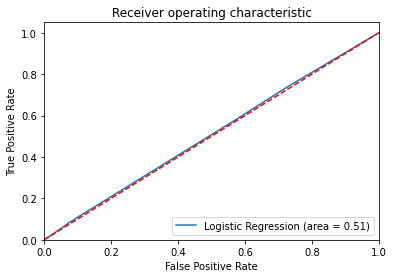



Decision Tree model: max_depth=4, splitter=best, max_feature=sqrt, n_components=110
Utility score:  87.79645361451446
Accuracy:  0.5065392020181902
Confusion matrix


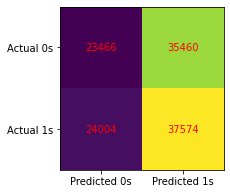

AUC_ROC


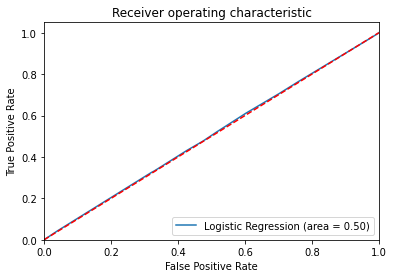



Decision Tree model: max_depth=4, splitter=best, max_feature=sqrt, n_components=130
Utility score:  371.25283100107305
Accuracy:  0.5044396866494059
Confusion matrix


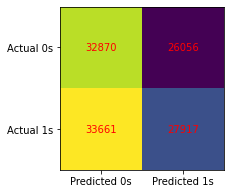

AUC_ROC


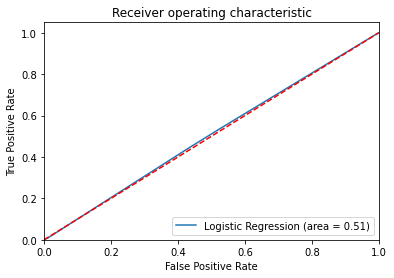



Decision Tree model: max_depth=4, splitter=best, max_feature=log2, n_components=70
Utility score:  212.32604134391244
Accuracy:  0.5146219212640244
Confusion matrix


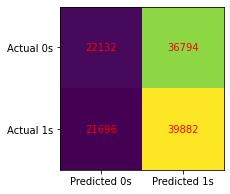

AUC_ROC


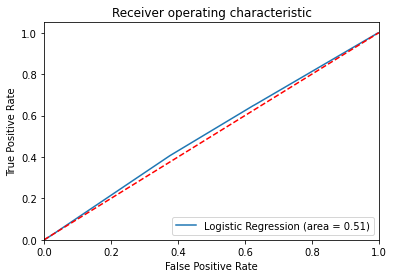



Decision Tree model: max_depth=4, splitter=best, max_feature=log2, n_components=90
Utility score:  -0.0
Accuracy:  0.5115431852884551
Confusion matrix


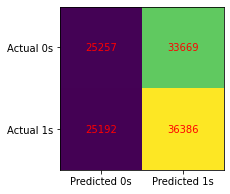

AUC_ROC


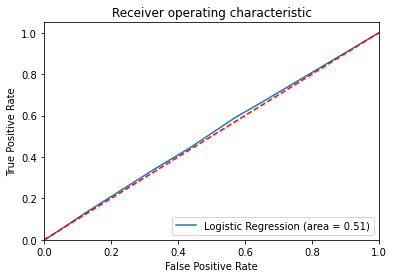



Decision Tree model: max_depth=4, splitter=best, max_feature=log2, n_components=110
Utility score:  54.59974402247239
Accuracy:  0.5105224722830778
Confusion matrix


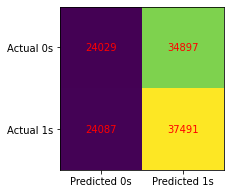

AUC_ROC


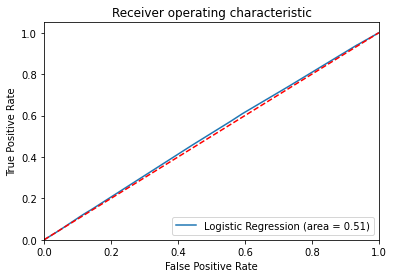



Decision Tree model: max_depth=4, splitter=best, max_feature=log2, n_components=130
Utility score:  37.26319016179379
Accuracy:  0.5139580428865432
Confusion matrix


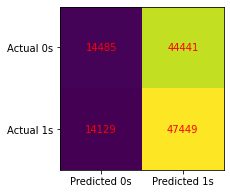

AUC_ROC


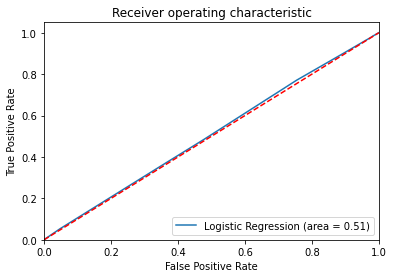



Decision Tree model: max_depth=4, splitter=random, max_feature=None, n_components=70
Utility score:  43.54422903518439
Accuracy:  0.5117589457611366
Confusion matrix


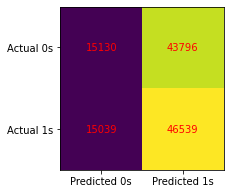

AUC_ROC


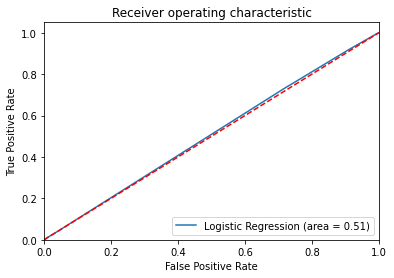



Decision Tree model: max_depth=4, splitter=random, max_feature=None, n_components=90
Utility score:  30.13920380404107
Accuracy:  0.5113025293766182
Confusion matrix


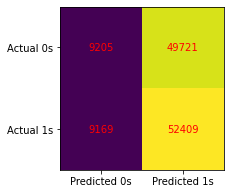

AUC_ROC


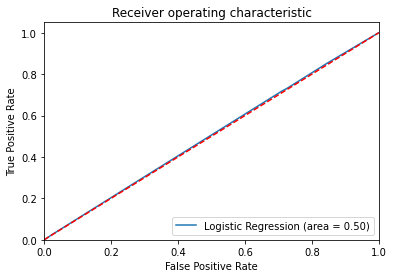



Decision Tree model: max_depth=4, splitter=random, max_feature=None, n_components=110
Utility score:  -0.0
Accuracy:  0.5116759609639514
Confusion matrix


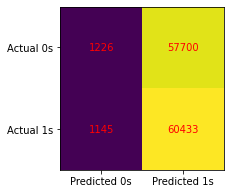

AUC_ROC


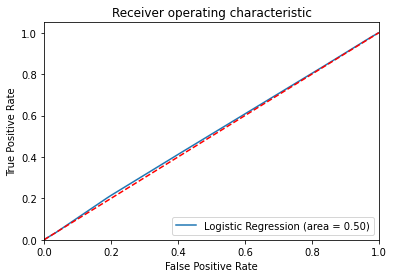



Decision Tree model: max_depth=4, splitter=random, max_feature=None, n_components=130
Utility score:  -0.0
Accuracy:  0.5115431852884551
Confusion matrix


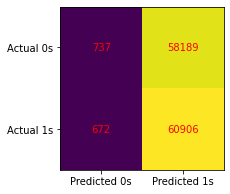

AUC_ROC


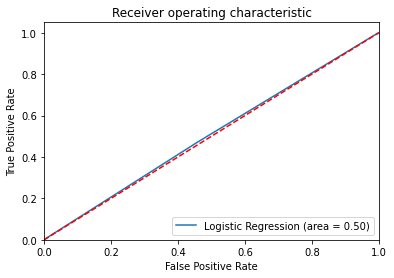



Decision Tree model: max_depth=4, splitter=random, max_feature=sqrt, n_components=70
Utility score:  -0.0
Accuracy:  0.5117506472814181
Confusion matrix


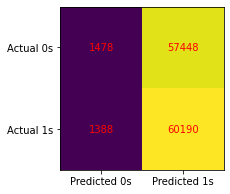

AUC_ROC


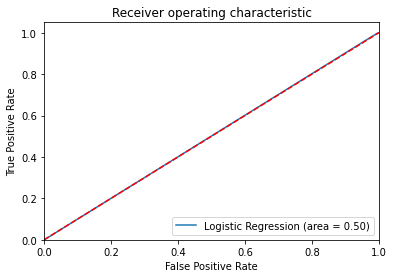



Decision Tree model: max_depth=4, splitter=random, max_feature=sqrt, n_components=90
Utility score:  -0.0
Accuracy:  0.5108212175529443
Confusion matrix


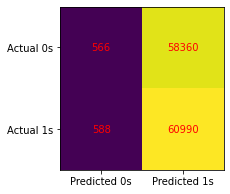

AUC_ROC


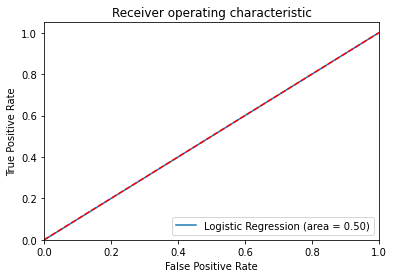



Decision Tree model: max_depth=4, splitter=random, max_feature=sqrt, n_components=110
Utility score:  -0.0
Accuracy:  0.5103150102901148
Confusion matrix


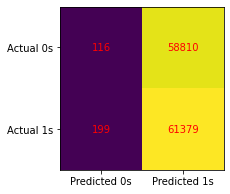

AUC_ROC


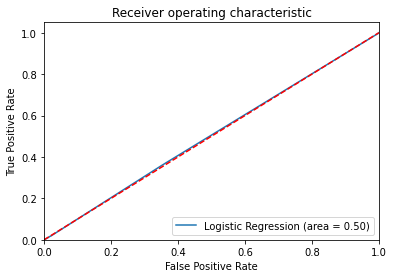



Decision Tree model: max_depth=4, splitter=random, max_feature=sqrt, n_components=130
Utility score:  -0.0
Accuracy:  0.5105888601208258
Confusion matrix


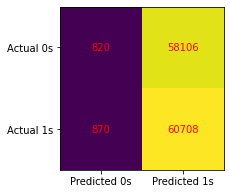

AUC_ROC


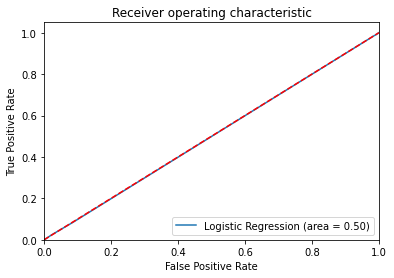



Decision Tree model: max_depth=4, splitter=random, max_feature=log2, n_components=70
Utility score:  -0.0
Accuracy:  0.5086968067450043
Confusion matrix


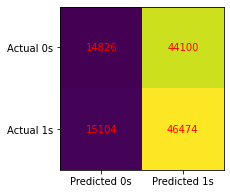

AUC_ROC


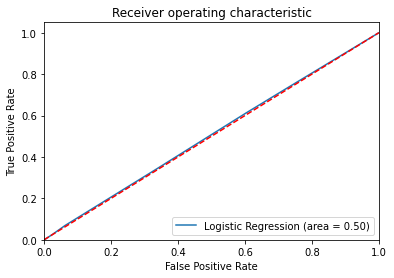



Decision Tree model: max_depth=4, splitter=random, max_feature=log2, n_components=90
Utility score:  -0.0
Accuracy:  0.5109871871473146
Confusion matrix


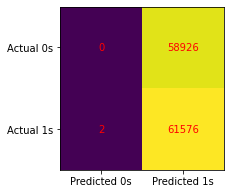

AUC_ROC


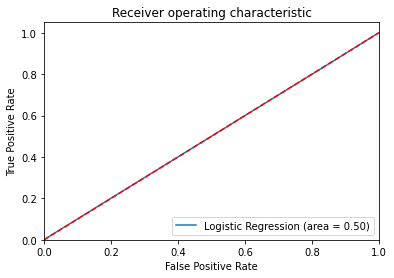



Decision Tree model: max_depth=4, splitter=random, max_feature=log2, n_components=110
Utility score:  -0.0
Accuracy:  0.5108710084312554
Confusion matrix


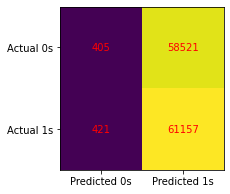

AUC_ROC


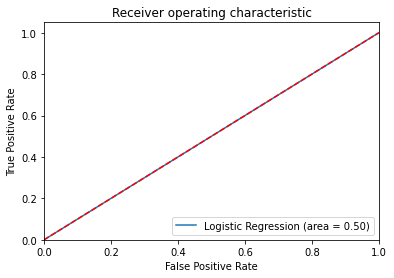



Decision Tree model: max_depth=4, splitter=random, max_feature=log2, n_components=130
Utility score:  -0.0
Accuracy:  0.5115348868087366
Confusion matrix


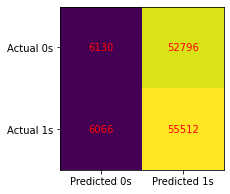

AUC_ROC


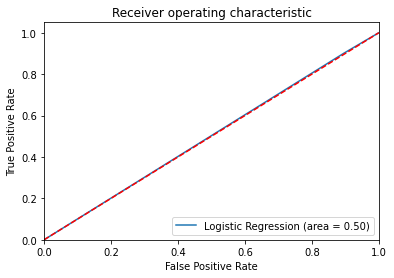



Decision Tree model: max_depth=8, splitter=best, max_feature=None, n_components=70
Utility score:  65.40520087995932
Accuracy:  0.5068711412069309
Confusion matrix


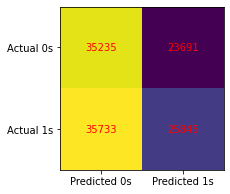

AUC_ROC


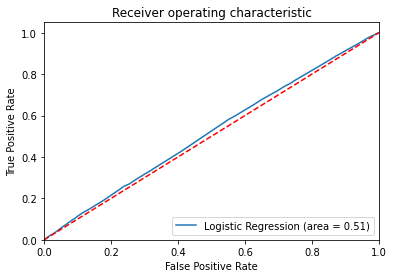



Decision Tree model: max_depth=8, splitter=best, max_feature=None, n_components=90


In [ ]:
# iterate over settings for the model
for max_depth in max_depths:
  for splitter in splitters:
    for max_feature in max_features:
      for n_component in n_components:
        pca = decomposition.PCA(n_components=n_component)
        pca.fit(x_train)
        x_train_pca = pca.transform(x_train)
        x_test_pca = pca.transform(x_test)

        print(f"\n\nDecision Tree model: max_depth={max_depth}, splitter={splitter}, max_feature={max_feature}, n_components={n_component}")    

        model = DecisionTreeClassifier(
            max_depth=max_depth, 
            splitter=splitter,
            max_features=max_feature
        )

        model.fit(x_train_pca, y_train)
        model_scores(model, x_test=x_test_pca)
        # tree.plot_tree(model)

# Conclusion

* Utility score: 
* Accuracy: 